This lab session in an introduction to feed-forward neural network with pytorch. We use the dataset Fashion-MNIST (see for more details this website https://github.com/zalandoresearch/fashion-mnist). The dataset contains 60000 and 10000 images for respectively training and testing. Each image is 28x28 pixels, for a total of 784 per image.  An image is presented to the neural network as a flat vector of 784 component. 


In this lab session, you will experiment different kind of feed-forward networks, starting with simple models,  and then increasing their complexity. 

First load and test python and pytorch. Your notebook is supposed to work with python 3 (see the top right corner of the notebook).



In [1]:
import torch as th
import torch.nn as nn

import numpy as np
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'
print(th.__version__) # should be greater or equal to 1.0


2.0.0+cu117


# Dataset

To simplify, just download and / or read the picke file provided. 


In [2]:
import gzip
fp = gzip.open('fashion-mnist.pk.gz','rb')
allXtrain, allYtrain, Xtest, Ytest, classlist  = pickle.load(fp) 

**Important**: The dataset is split in two parts, the training set and the test set.
For thorough study and evaluation of machine learning models, a good practice is to consider the data in 3 parts: 
- the **training** set to learn the model parameters;
- the **validation** set to tune the hyper parameters and some design choices (the number and the size of the hidden layers, the dropout probability, ...);
- the **test** set to evaluate the model at the end. 


For the moment, we leave the test set and focus on the training set. 
To spare time, we will only consider the first 20000 images for training in the following set of experiments. And we also build a validation set to compare the results we obtain with different hyper-parameters. 




In [3]:
Xtrain, Ytrain  = allXtrain[:20000], allYtrain[:20000]
Xvalid, Yvalid  = allXtrain[20000:30000], allYtrain[20000:30000]
print("Training   shape:" ,Xtrain.shape)
print("Validation shape:" ,Xvalid.shape)

Training   shape: torch.Size([20000, 784])
Validation shape: torch.Size([10000, 784])


To better understand the dataset explore the training set made of Xtrain and Ytrain. 
- Look at the dimension and type of the tensors
- Print also the classlist variable. 
- Then look at some example to check consistency. 

For that purpose you can plot an image like this: 

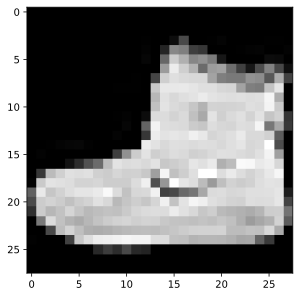

In [4]:
plt.imshow(Xtrain[0].numpy().reshape(28,28) , matplotlib.pyplot.cm.gray)



As a first overview of the dataset, we can do a PCA (in 2D) of the training set. The following image represents the result: 

<img src="https://allauzen.github.io/assets/figs/pca-fashion-10-classes.png" 
    style="width:400px; margin:0px auto;display:block">



# Feed forward neural network



A feedforward model can rely on the pytorch module *Sequential*. 
A *Sequential* module is a container of ordered modules: the first one takes input data and its output is given to feed the second module, and so on. 

**Note: ** In pytorch, modules assumed Tensors as input. The input Tensor can contain just one input (online mode) or several inputs (mini-batch). The first dimension of the input Tensor corresponds to the mini-batch, and the second one to the dimension of the example to feed in. For example, with a mini-batch of size B and an image of D pixels, the input Tensor should be of shape (B,D), even if B=1 for one exemple. 


## Shallow network

Let start with a simple model with one input layer and one output layer (without hidden layers). Please refer to the examples provided previously, and propose an implementation of this linear model using the *Sequential* module as container.  To write the model, we must consider the fact that the model is trained in order to maximize the Log-likelihood on the training data. If you look at  https://pytorch.org/docs/stable/nn.html, the documentation of the NNet package of pytorch, there is a section on the loss functions. 

Two of the proposed loss function can be used for our purpose. The choice of one of them implies the choice of the activation function at the output layer. 

- What are these two possible choices ? 

The two possible choices are :

- NLLLoss()
- CrossEntropyLoss()

Make a choice and replace the "None" in the following cell:

In [5]:
D_in = 784
D_out= 10

## TODO : replace "None"
model =  th.nn.Sequential(
    th.nn.Linear(D_in, D_out),   
)
loss_function = nn.CrossEntropyLoss() 


Then test the code on a minibatch of B examples. The code below corresponds to a prediction on a single image and then on 3 images. Look at the results, their shapes and values. Is it consistent with what you expect ? 

In [22]:
B=1
i = 0
pred = model(Xtrain[i:i+B])
# explore 
print(pred)
B=3
i = 0
pred = model(Xtrain[i:i+B])
print(pred)

tensor([[  95.7831,  -13.9269,  -53.1407, -136.7948,   28.6512, -110.9712,
          -39.9801,  216.5504, -147.6397,  -16.1069]],
       grad_fn=<AddmmBackward0>)
tensor([[  95.7832,  -13.9269,  -53.1407, -136.7948,   28.6512, -110.9713,
          -39.9801,  216.5504, -147.6397,  -16.1069],
        [ 140.1534,   33.1480,  -33.0648, -168.3729,   36.2106, -186.8804,
            4.6077,  165.8936, -221.1334,   15.5160],
        [  35.0006,   28.5751,   10.8513,  -54.6000,   33.7055,  -76.7546,
           13.8468,   89.4352,  -34.3705,   13.0179]],
       grad_fn=<AddmmBackward0>)


Do the same with the loss function. 

In [23]:
B=1
i = 1
pred = model(Xtrain[i:i+B])
loss = loss_function(pred, Ytrain[i:i+B])
print(loss)
# explore 
B=3
i = 1
pred = model(Xtrain[i:i+B])
loss = loss_function(pred, Ytrain[i:i+B])
print(loss)

tensor(25.7403, grad_fn=<NllLossBackward0>)
tensor(81.8441, grad_fn=<NllLossBackward0>)


## Online learning  and mini-batch

We will start by writing the code for training a model. The code should be as generic as possible to handle different kind of model. Afterwards, you will wrap your code in a function. 

We will use the Adam optimizer with an initial learning rate of 0.001.  

The following cell contains examples of code that can be useful to train the model:  
- Init. of the model and the optimizer.  
- Ideas the iterate over the dataset in a random order
- Mini-batch processing 
- Forward and backward pass

In [18]:
### The model, the loss and optimizer
model=nn.Sequential(nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1))
optimizer=th.optim.Adam(model.parameters(),lr=0.001)
loss_fn=nn.NLLLoss()

### Mini-batching and shuffle 
Ntrain = Xtrain.shape[0] 
Nvalid = Xvalid.shape[0]
print(Ntrain,Nvalid)
idx = np.arange(Ntrain) # Generate the indices 
batch_size = 200
nbatch = int(Ntrain/batch_size) # the number of batches
print(batch_size, nbatch)

np.random.shuffle(idx) # random order of indices 
bi = 2 # a random choice
ids = idx[bi*batch_size:(bi+1)*batch_size] # Get indices
images = Xtrain[ids]  # Get the images
labels = Ytrain[ids]  # The Labels
optimizer.zero_grad()
logprobs=model(images) # inference 
loss=loss_fn(logprobs,labels) # compute the loss
print("Loss function: ",loss)     
loss.backward() # Back propagation
optimizer.step() # update the parameters
# Note: just for illustration and checking, we can recompute 
# the loss on the same minibatch, but after the update. 
logprobs=model(images) # inference 
loss=loss_fn(logprobs,labels) # compute the loss
print("Loss function: ",loss.item()) # better print ! 


20000 10000
200 100
Loss function:  tensor(123.3846, grad_fn=<NllLossBackward0>)
Loss function:  70.28295135498047


Given the previous example, write the "full" training: 
- Init. of everything useful
- The training loop, 
- ... 

Remember that we need the values of the loss function both on the train and on the validation set. 

In [50]:
Nepochs=30

### The model, the loss and optimizer
model=nn.Sequential(nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1))
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
loss_fn=nn.NLLLoss()


### Mini-batching and shuffle 
Ntrain = Xtrain.shape[0] 
Nvalid = Xvalid.shape[0]
print(Ntrain,Nvalid)
idx = np.arange(Ntrain) # Generate the indices 
batch_size = 200
nbatch = int(Ntrain/batch_size) # the number of batches
print(batch_size, nbatch)

np.random.shuffle(idx) # random order of indices 
bi = 2 # a random choice
ids = idx[bi*batch_size:(bi+1)*batch_size] # Get indices
images = Xtrain[ids]  # Get the images
labels = Ytrain[ids]  # The Labels



train_losses = np.zeros(Nepochs)
valid_losses = np.zeros(Nepochs)
valid_accuracies = np.zeros(Nepochs)

for i in range(Nepochs):
    np.random.shuffle(idx) # random order of indices 
    for bi in range(nbatch):
        ids = idx[bi*batch_size:(bi+1)*batch_size] # Get indices
        images = Xtrain[ids]  # Get the images
        labels = Ytrain[ids]  # The Labels
        optimizer.zero_grad()
    
        logprobs=model(images) # inference 
        loss=loss_fn(logprobs,labels) # compute the loss
        train_losses[i] += loss/nbatch

        loss.backward() # Back propagation
        optimizer.step() # update the parameters
    
    logprobsV=model(Xvalid) # inference 
    valid_losses[i]=loss_fn(logprobsV,Yvalid) # compute the loss

    class_valid = th.argmax(logprobsV, dim=1)
    valid_accuracies[i]=th.sum(class_valid==Yvalid)/Nvalid*100

    


20000 10000
200 100


Run the training loop with a batch size of 1 and then of size 200. The difference in terms of computation time should be significant ! We will now only use a batch size of 200. 

Note that in practice, the learning rate should be adapted to the mini-batch size. 

Run the previous training code with a batch size of 200 for 30 epochs. We can plot at the results like this


(0.0, 79.75899353027344)

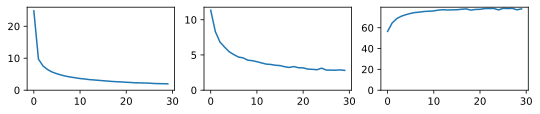

In [51]:
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 3, 1)
plt.plot(train_losses)
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 2)
plt.plot(valid_losses)
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
ax.set_ylim(bottom=0)

## Training wrapper 

Write a function that wraps what we need to train a model and look at the results. Test it with a new model. 

Good to notice : the call of  *model(X)* return a 2D tensor. The 2D tensor has a line for every image of the batch. The line of an image has one column per label (here 10). The tensor contains the log-probabilities that the image corresponds to the label of the
column.


In [6]:
def train(model, epochs=30,verbose=False):
    loss_fn=nn.NLLLoss()
    ### Mini-batching and shuffle 
    Ntrain = Xtrain.shape[0] 
    Nvalid = Xvalid.shape[0]
    print(Ntrain,Nvalid)
    idx = np.arange(Ntrain) # Generate the indices 
    batch_size = 200
    nbatch = int(Ntrain/batch_size) # the number of batches
    print(batch_size, nbatch)

    np.random.shuffle(idx) # random order of indices 
    bi = 2 # a random choice
    ids = idx[bi*batch_size:(bi+1)*batch_size] # Get indices
    images = Xtrain[ids]  # Get the images
    labels = Ytrain[ids]  # The Labels

    for i in range(epochs):
        np.random.shuffle(idx) # random order of indices 
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size] # Get indices
            images = Xtrain[ids]  # Get the images
            labels = Ytrain[ids]  # The Labels
            optimizer.zero_grad()
        
            logprobs=model(images) # inference 
            loss=loss_fn(logprobs,labels) # compute the loss

            loss.backward() # Back propagation
            optimizer.step() # update the parameters

    logprobs=model(Xtrain) # inference 
    print('Loss for train : ', loss_fn(logprobs,Ytrain))

    logprobsV=model(Xvalid) # inference 
    print('Loss for validation : ', loss_fn(logprobsV,Yvalid))

    class_valid = th.argmax(logprobsV, dim=1)
    print("Validation accuracy : ", th.sum(class_valid==Yvalid)/Nvalid*100)

# When we create the model, its parameters are initialized. 
model=nn.Sequential(nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1))
optimizer=th.optim.Adam(model.parameters(),lr=0.001)
# Note this important to build a new optimizer 
# if we want to have the reference to parameters 
# of the new model ! 
train(model)

20000 10000
200 100
Loss for train :  tensor(2.3326, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(4.2338, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(79.2800)


# Neural Network with one hidden layer

Now we have a function to train and evaluate the training process of a neural model, we can explore different configurations. Let start with a neural network with one hidden layer and a Sigmoid activation function on this hidden layer. We set the size of this hidden layer to 50. 

Write the model using the Sequential module, and train it: 
- for 30 epochs and with lr=0.001 and lr=0.0001
- do the same and raise the number of epoch to 50
What do you observe ? 

In [66]:
## TODO 
D_in = 784
D_out= 10
hidden_layer = 50

model=nn.Sequential(nn.Linear(D_in,hidden_layer),
                    nn.Sigmoid(),
                    nn.Linear(hidden_layer,D_out),
                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.001)
train(model, epochs=50)

20000 10000
200 100
Loss for train :  tensor(0.5304, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(0.5536, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(80.5900)


Pour l_r = 0.001, epochs = 30, Loss_train = 0.53, Loss_validate = 0.54, Validation accuracy = 80%

Pour l_r = 0.0001, epochs = 30, Loss_train = 0.51, Loss_validate = 0.55, Validation accuracy = 83%

Pour l_r = 0.001, epochs = 50, Loss_train = 0.53, Loss_validate = 0.55, Validation accuracy = 81%

Pour l_r = 0.0001, epochs = 50, Loss_train = 0.38, Loss_validate = 0.45, Validation accuracy = 84%

## From Sigmoid to ReLU

Consider lr=0.0001 and train a similar model with a ReLU activation. Compare the results. 

In [7]:
D_in = 784
D_out= 10
hidden_layer = 50

model=nn.Sequential(nn.Linear(D_in,hidden_layer),
                    nn.ReLU(),
                    nn.Linear(hidden_layer,D_out),
                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
train(model, epochs=50)

20000 10000
200 100
Loss for train :  tensor(0.2643, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(0.5109, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(84.7900)


En remplaçant Sigmoid par ReLU :
Pour l_r = 0.0001, epochs = 50, Loss_train = 0.23, Loss_validate = 0.52, Validation accuracy = 85%

## Impact of the hidden layer size

Run experiments with different hidden layer size, respectively : 50,100,150, 200 and 250. 
What do you observe ? 


In [69]:
D_in = 784
D_out= 10
hidden_layer = 200

model=nn.Sequential(nn.Linear(D_in,hidden_layer),
                    nn.ReLU(),
                    nn.Linear(hidden_layer,D_out),
                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
train(model, epochs=50)

20000 10000
200 100
Loss for train :  tensor(0.0685, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(0.7339, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(85.5400)


Pour l_r = 0.0001, epochs = 50:

H_L = 50, Loss_train = 0.23, Loss_validate = 0.52, Validation accuracy = 85%

H_L = 100, Loss_train = 0.11, Loss_validate = 0.68, Validation accuracy = 85%

H_L = 150, Loss_train = 0.08, Loss_validate = 0.71, Validation accuracy = 85%

H_L = 200, Loss_train = 0.07, Loss_validate = 0.73, Validation accuracy = 85%

# Deeper network

Now we add one more hidden layer and consider a NNet with two hidden layers. 
The first setup is: 
- two hidden layers of size 50 with a ReLU activation
- a learning rate of 0.0001

Train it during 100 epochs 

In [71]:
D_in = 784
D_out= 10
hidden_layer = 50

model=nn.Sequential(nn.Linear(D_in,hidden_layer),
                    nn.ReLU(),
                    nn.Linear(hidden_layer,hidden_layer),
                    nn.ReLU(),
                    nn.Linear(hidden_layer,D_out),
                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
train(model, epochs=100)

20000 10000
200 100
Loss for train :  tensor(0.0977, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(0.5910, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(86.)


Loss_train = 0.09, loss_validate = 0.59, Validation accuracy = 86%


Try different value of dropout to assess its impact on the training process. For example 0.3 and 0.5. 

In [76]:
D_in = 784
D_out= 10
hidden_layer = 50

model=nn.Sequential(nn.Linear(D_in,hidden_layer),
                    nn.Dropout(0.3),
                    nn.ReLU(),
                    nn.Linear(hidden_layer,hidden_layer),
                    nn.Dropout(0.3),
                    nn.ReLU(),
                    nn.Linear(hidden_layer,D_out),
                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
train(model, epochs=50)

20000 10000
200 100
Loss for train :  tensor(0.5667, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(0.6645, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(77.0900)


Pour 0.3 : Loss_train = 0.57, loss_validate = 0.66, Validation accuracy = 77%

Pour 0.5 : Loss_train = 1.28, loss_validate = 1.34, Validation accuracy = 48%


Then you can play with different  "hyper-parameters":
- Increase the size (double for example) of the first hidden layer
- Add a third hidden layer. 


In [79]:
D_in = 784
D_out= 10
hidden_layer_1 = 25
hidden_layer_2 = 50
hidden_layer_3 = 25

model=nn.Sequential(nn.Linear(D_in,hidden_layer_1),
                    nn.Dropout(0.3),
                    nn.ReLU(),
                    nn.Linear(hidden_layer_1,hidden_layer_2),
                    nn.Dropout(0.3),
                    nn.ReLU(),
                    nn.Linear(hidden_layer_2,hidden_layer_3),
                    nn.Dropout(0.3),
                    nn.ReLU(),
                    nn.Linear(hidden_layer_3,D_out),
                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
train(model, epochs=50)

20000 10000
200 100
Loss for train :  tensor(0.9616, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(1.0221, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(59.7000)


Pour dropout = 0.3, hidden_layer_1 = 25, hidden_layer_1 = 50

Loss_train = 0.90, Loss_validation = 0.96, Validation_accurency = 63%


Pour dropout = 0.3, hidden_layer_1 = 25, hidden_layer_1 = 50, hidden_layer_3 = 25

Loss_train = 0.96, Loss_validation = 1.02, Validation_accurency = 59.7%

# Confusion matrix

For a good model you obtained, compute the confusion matrix and look at it. 


In [8]:
from sklearn.metrics import confusion_matrix


D_in = 784
D_out= 10
hidden_layer = 50

model=nn.Sequential(nn.Linear(D_in,hidden_layer),
                    nn.ReLU(),
                    nn.Linear(hidden_layer,D_out),
                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
train(model, epochs=50)

with th.no_grad():
    # Get predictions on the test set
    logits = model(Xvalid)
    predictions = th.argmax(logits, dim=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Yvalid.numpy(), predictions.numpy())
print(conf_matrix)

20000 10000
200 100
Loss for train :  tensor(0.2181, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(0.5456, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(84.6100)
[[794   8  33  36   2   1 126   1   9   0]
 [  1 960   7  16   2   0   3   0   1   0]
 [  6   4 789  14 120   1  67   0   6   0]
 [ 31  26  13 849  40   1  41   0   4   1]
 [  2   1 109  22 791   0  62   0   4   2]
 [  0   0   0   2   2 932   2  43  11  28]
 [111   5 125  36 115   1 609   0  11   0]
 [  0   0   0   0   0  39   0 918   6  55]
 [  9   0  10  15   6  12  14   3 931   1]
 [  0   0   0   0   0  19   0  34   1 888]]



# Dropout 

You should observe overfitting. One solution is to add a dropout layer to the model (with a probability of 0.2 for example). Code this modification and rerun the training process to observe the impact. When you use a Dropout layer, the layer acts differently in the train mode and evaluation mode. You should take this into account when you train the model end when you compute the performance on the validation set. 



In [10]:
D_in = 784
D_out= 10
hidden_layer = 50

model=nn.Sequential(nn.Linear(D_in,hidden_layer),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(hidden_layer,D_out),

                    nn.LogSoftmax(dim=1))
                    
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)
train(model, epochs=50)

with th.no_grad():
    # Get predictions on the test set
    logits = model(Xvalid)
    predictions = th.argmax(logits, dim=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Yvalid.numpy(), predictions.numpy())
print(conf_matrix)

20000 10000
200 100
Loss for train :  tensor(0.4586, grad_fn=<NllLossBackward0>)
Loss for validation :  tensor(0.6360, grad_fn=<NllLossBackward0>)
Validation accuracy :  tensor(79.3300)
[[784  10  29  87  12   2  73   0  13   0]
 [  5 911  13  54   4   0   2   0   0   1]
 [ 28  14 743  21 160   0  34   0   7   0]
 [ 74  15  18 809  55   0  32   1   2   0]
 [  1  11 164  77 632   1 101   1   5   0]
 [  1   0   2   2   0 931   0  55   7  22]
 [152   4 180  51 161   2 447   1  15   0]
 [  0   0   0   1   0  52   0 911   5  49]
 [  7   0   8  19   9  17  23   8 910   0]
 [  0   0   0   4   2  34   0  44   9 849]]


# PCA 

To analyse the results, beyond the confusion matrix, we can compute the PCA (in 2D) and plot the projected datapoints depending on their classes, for instance by considering every pairs of classes. To compute the PCA and project the data, we can use the implementation provided by sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 

In [25]:
# compute the PCA in 2D
from sklearn.decomposition import PCA
#  .... 
pca = PCA(n_components=2)

# fit the PCA model to the data
pca.fit(Xtrain)

# transform the data using the fitted PCA model
X_pca = pca.transform(Xtrain)

# Test 
- Take two best models (with one and two hidden layers) and run the evaluation on the test set. 
- Train the best two models with all the training data and compute the results on the test set. 
